### Read from DB ###

In [1]:
import sqlalchemy as sql
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [2]:
engine=sql.create_engine('sqlite:///solana_price_db.db')

In [3]:
engine.table_names()

['solana_price']

In [4]:
df=pd.read_sql_table('solana_price', con=engine, index_col='Date', parse_dates=True)
df=df.drop(columns='index')
df.head()

,Close,Volume,Ticker
Date,,,
2020-04-10,0.951054,87364276,SOL
2020-04-11,0.776819,43862444,SOL
2020-04-12,0.882507,38736897,SOL
2020-04-13,0.777832,18211285,SOL
2020-04-14,0.661925,16747614,SOL


In [5]:
df.index

DatetimeIndex(['2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
               '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
               '2020-04-18', '2020-04-19',
               ...
               '2022-07-30', '2022-07-31', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-06',
               '2022-08-07', '2022-08-08'],
              dtype='datetime64[ns]', name='Date', length=851, freq=None)

<AxesSubplot:xlabel='Date'>

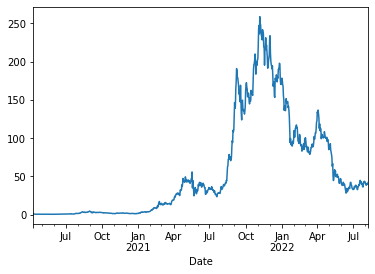

In [6]:
df['Close'].plot()

### ML ###

create a table like below: 
<img src='./images/sample_features.png' width=720>

In [7]:
features=df[['Close']]
window_size=5
for i in range(1, window_size+1): 
    features[f'Close T-{i}']=features['Close'].shift(i)

features=features.dropna()
features.head()

,Close,Close T-1,Close T-2,Close T-3,Close T-4,Close T-5
Date,,,,,,
2020-04-15,0.646651,0.661925,0.777832,0.882507,0.776819,0.951054
2020-04-16,0.690816,0.646651,0.661925,0.777832,0.882507,0.776819
2020-04-17,0.660728,0.690816,0.646651,0.661925,0.777832,0.882507
2020-04-18,0.681096,0.660728,0.690816,0.646651,0.661925,0.777832
2020-04-19,0.606969,0.681096,0.660728,0.690816,0.646651,0.661925


In [8]:
y=features[['Close']]
X=features.drop(columns=['Close'])

Split into training and testing

In [9]:
# split at 2021 / 6
X_train=X.loc[:'2021-12']
y_train=y.loc[:'2021-12']
X_test=X.loc['2022-01':]
y_test=y.loc['2022-01':]

In [10]:
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(626, 5)

(220, 5)

(626, 1)

(220, 1)

### Scale Data ###

In [11]:
from sklearn.preprocessing import MinMaxScaler
X_scaler=MinMaxScaler()
X_scaler.fit(X_train)
X_train_scaled=X_scaler.transform(X_train)
X_test_scaled=X_scaler.transform(X_test)

In [12]:
y_scaler=MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled=y_scaler.transform(y_train)
y_test_scaled=y_scaler.transform(y_test)

### Reshape ###

In [13]:
X_train_scaled=X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_scaled=X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], 1)

### Build Model ###

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [15]:
model=Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=30))
model.add(Dense(units=1, activation='linear'))

2022-08-21 22:44:15.863449: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 30)             3840      
                                                                 
 dropout (Dropout)           (None, 5, 30)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 30)             7320      
                                                                 
 dropout_1 (Dropout)         (None, 5, 30)             0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-traina

In [17]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error')

In [18]:
model.fit(X_train_scaled, y_train_scaled, epochs=50)

Epoch 1/50
20/20 [==============================] - 4s 9ms/step - loss: 0.0732 - mean_squared_error: 0.0732
Epoch 2/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0226 - mean_squared_error: 0.0226
Epoch 3/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 4/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 5/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 6/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 7/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 8/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 9/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 10/50
20/20 [=========

In [19]:
y_predicted=model.predict(X_test_scaled)

7/7 [==============================] - 1s 4ms/step


### Plot Prediction ###

In [20]:
import matplotlib.pyplot as plt

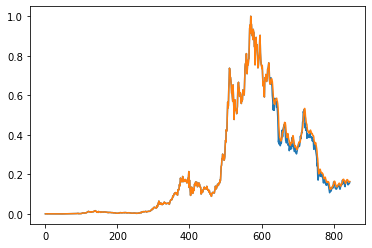

In [21]:
price=np.concatenate([y_train_scaled.ravel(), y_test_scaled.ravel()])
prediction=np.concatenate([y_train_scaled.ravel(), y_predicted.ravel()])
fig=plt.figure()
plt.plot(price)
plt.plot(prediction)

In [22]:
next_prediction_input=df.iloc[-5:]['Close'].values
next_prediction_input_scaled=X_scaler.transform([next_prediction_input])

In [23]:
next_prediction_input_scaled

array([[0.14826848, 0.15496442, 0.153014  , 0.15513685, 0.16119275]])

In [24]:
next_prediction=model.predict([next_prediction_input_scaled])
next_prediction

1/1 [==============================] - 1s 814ms/step


array([[0.1624452]], dtype=float32)

In [25]:
y_scaler.inverse_transform(next_prediction)

array([[42.494205]], dtype=float32)